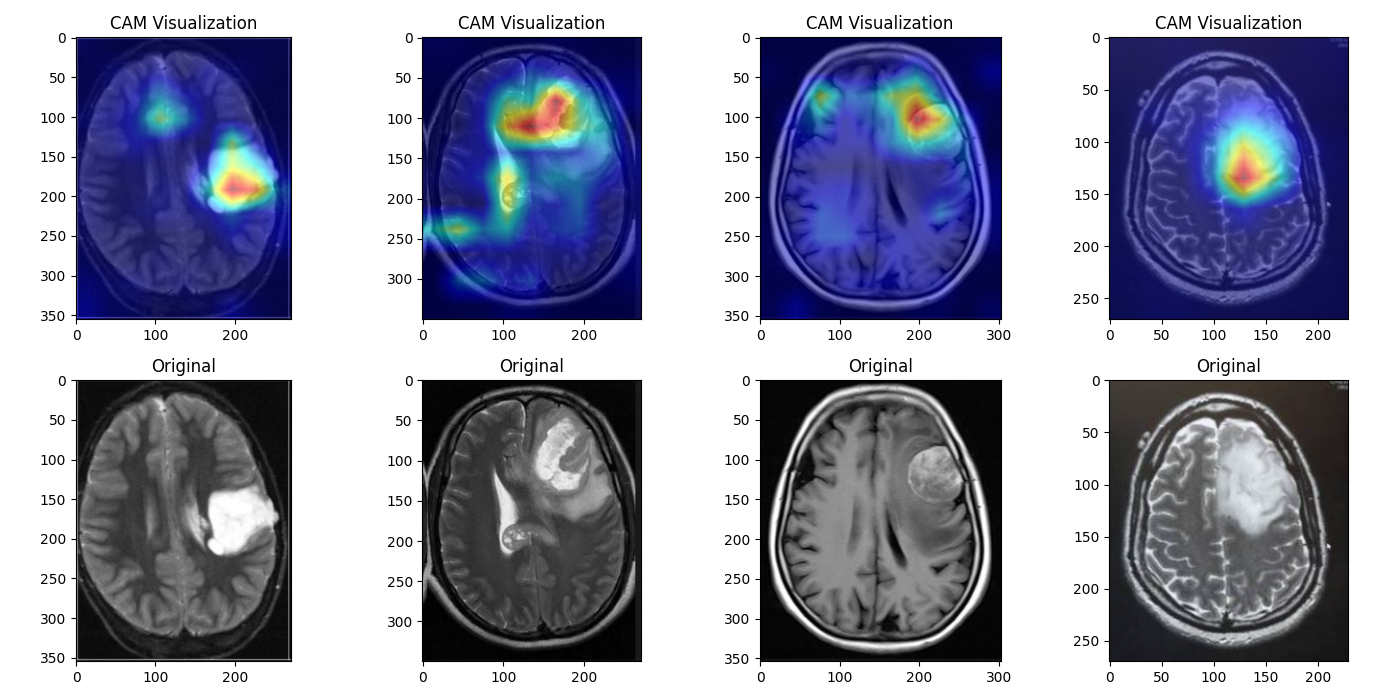

In [1]:
!pip install -q grad-cam

In [2]:
from PIL import Image
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from tqdm import tqdm
from typing import Tuple
import matplotlib.pyplot as plt
import kornia.augmentation as K
import torch.optim as optim
import matplotlib
import torch
import torch.nn as nn
import numpy as np
import os
import random

In [3]:
tumors_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/yes/"
no_tumors_path = "/kaggle/input/brain-mri-images-for-brain-tumor-detection/no/"

augmented_tumors_path = "augmented_dataset/yes/"
augmented_no_tumors_path = "augmented_dataset/no/"

try:
    os.mkdir("augmented_dataset")
    os.mkdir("augmented_dataset/yes")
    os.mkdir("augmented_dataset/no")
except:
    pass
        
def generate_augmentations(path, augmented_path):
    augmentations = [
        K.RandomHorizontalFlip(p=1.0),
        K.RandomVerticalFlip(p=1.0),        
        K.RandomRotation(degrees=15, p=1.0),
        K.RandomAffine(degrees=15, p=1.0),
        K.RandomElasticTransform(p=1.0),
        K.RandomGaussianBlur(kernel_size=(5, 9), p=1.0, sigma=(0.1, 5.0)),
        K.RandomSharpness(p=1.0),
    ]

    for image in os.listdir(path):
        img = Image.open(path + image).convert('L')
        file_extension = image.split(".")[1]
        file_name = image.split(".")[0].replace(" ", "-")
        img.save(f"{augmented_path}{file_name}_Original.{file_extension}")
        img = transforms.ToTensor()(img)
        for aug in augmentations:
            augmented = aug(img)
            augmented = augmented.squeeze(0)
            augmented = augmented.squeeze(0)
            augmented = transforms.ToPILImage()(augmented)
            augmented.save(f"{augmented_path}{file_name}_{aug.__class__.__name__}.{file_extension}")
    

generate_augmentations(tumors_path, augmented_tumors_path)
generate_augmentations(no_tumors_path, augmented_no_tumors_path)

print("Original dataset size: ", len(os.listdir(tumors_path)) + len(os.listdir(no_tumors_path)))
print("Augmented dataset size: ", len(os.listdir(augmented_tumors_path)) + len(os.listdir(augmented_no_tumors_path)))

Original dataset size:  253
Augmented dataset size:  2024


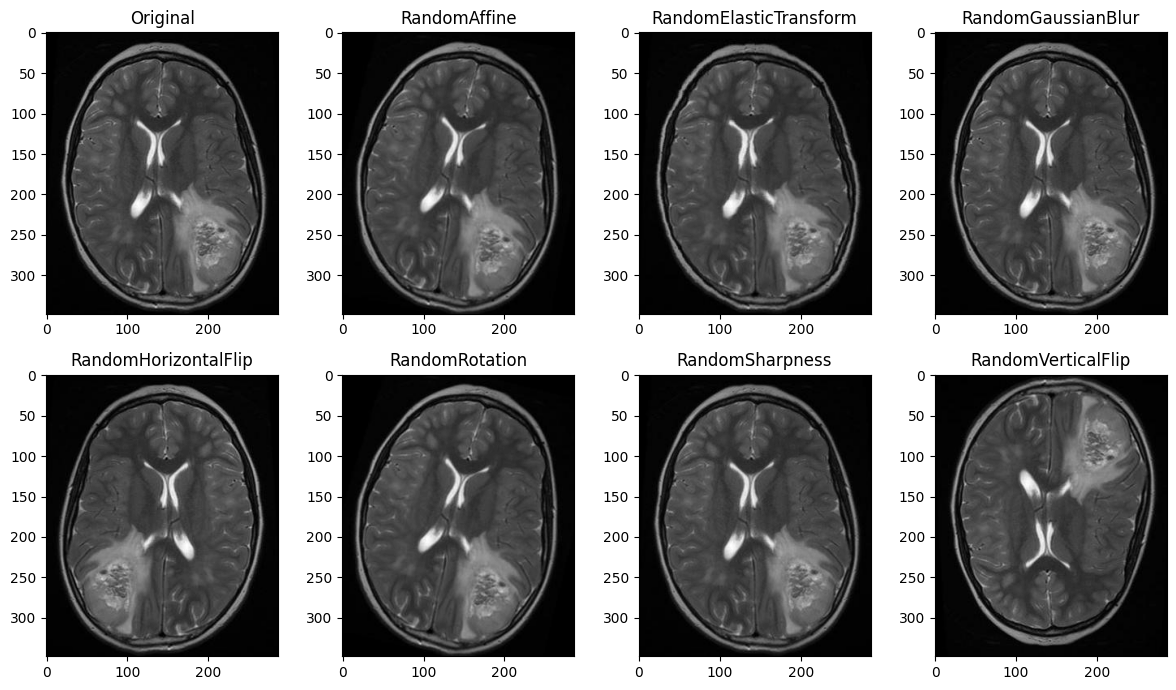

In [4]:
samples = [
    "/kaggle/working/augmented_dataset/yes/Y100_Original.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomAffine.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomElasticTransform.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomGaussianBlur.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomHorizontalFlip.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomRotation.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomSharpness.JPG",
    "/kaggle/working/augmented_dataset/yes/Y100_RandomVerticalFlip.JPG",
]

fig, axs = plt.subplots(2, 4, figsize=(12, 7))
start_index = 0
for row in range(2):
    for col in range(4):
        filename = Image.open(samples[start_index])
        aug_type = filename.filename.split("/")[-1].split("_")[-1].split(".")[0]
        axs[row, col].imshow(filename, cmap="gray")
        axs[row, col].set_title(aug_type)
        start_index += 1
plt.tight_layout()
plt.show()

In [5]:
def create_directory(path):
    try:
        os.makedirs(path)
    except FileExistsError:
        pass


def split_data(data, train_ratio=0.8, val_ratio=0.1):
    np.random.shuffle(data)
    train_end = int(len(data) * train_ratio)
    val_end = int(len(data) * (train_ratio + val_ratio))
    return data[:train_end], data[train_end:val_end], data[val_end:]


def save_images(data, source_dir, target_dir):
    for filename in data:
        img = Image.open(os.path.join(source_dir, filename))
        img.save(os.path.join(target_dir, filename))


augmented_tumors_path = "augmented_dataset/yes/"
augmented_no_tumors_path = "augmented_dataset/no/"
dataset_dirs = [
    "dataset/train/yes",
    "dataset/train/no",
    "dataset/val/yes",
    "dataset/val/no",
    "dataset/test/yes",
    "dataset/test/no"
]

for dir_path in dataset_dirs:
    create_directory(dir_path)

tumors = os.listdir(augmented_tumors_path)
no_tumors = os.listdir(augmented_no_tumors_path)

tumors_train, tumors_val, tumors_test = split_data(tumors)
no_tumors_train, no_tumors_val, no_tumors_test = split_data(no_tumors)

save_images(tumors_train, augmented_tumors_path, "dataset/train/yes")
save_images(tumors_val, augmented_tumors_path, "dataset/val/yes")
save_images(tumors_test, augmented_tumors_path, "dataset/test/yes")

save_images(no_tumors_train, augmented_no_tumors_path, "dataset/train/no")
save_images(no_tumors_val, augmented_no_tumors_path, "dataset/val/no")
save_images(no_tumors_test, augmented_no_tumors_path, "dataset/test/no")

In [6]:
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 16
NUM_WORKERS = 4
DATA_TYPES = ['train', 'val', 'test']

data_dir = '/kaggle/working/dataset'

data_transforms = transforms.Compose([
    transforms.Resize(IMAGE_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.2470, 0.2470, 0.2470], [0.2364, 0.2364, 0.2364])
])

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms) for x in DATA_TYPES}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) for x in DATA_TYPES}
dataset_sizes = {x: len(image_datasets[x]) for x in DATA_TYPES}
class_names = image_datasets['train'].classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# def find_mean_std(loader):
#     # VAR[X] = E[X**2] - E[X]**2
#     channels_sum, channels_squared_sum, num_batches = 0, 0, 0

#     for data, _ in loader:
#         channels_sum += torch.mean(data, dim=[0, 2, 3])
#         channels_squared_sum += torch.mean(data**2, dim=[0, 2, 3])
#         num_batches += 1

#     mean = channels_sum / num_batches
#     std = (channels_squared_sum / num_batches - mean**2)**0.5

#     return mean, std

# # Calculate mean and std for train data
# mean, std = find_mean_std(dataloaders['train'])

In [8]:
class Trainer:
    def __init__(
        self,
        device: str,
        model: torch.nn.Module,
        criterion: torch.nn.Module,
        optimizer: torch.optim.Optimizer,
        scheduler: torch.optim.lr_scheduler,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        test_dataloader: DataLoader,
        checkpoint_path: str
    ):
        self.device = device
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.test_dataloader = test_dataloader
        self.checkpoint_path = checkpoint_path
        self.best_accuracy = 0.0
        self.best_model_path = None

    def train(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.train()

        num_batches = len(self.train_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        loop = tqdm(self.train_dataloader, total=num_batches)
        for batch in loop:
            x, y = batch
            x, y = x.to(self.device), y.to(self.device)

            self.optimizer.zero_grad()

            y_hat = self.model(x)
            _, preds = torch.max(y_hat, 1)
            loss = self.criterion(y_hat, y)

            loss.backward()
            self.optimizer.step()

            running_loss += loss.item() * x.size(0)
            n_corrects += torch.sum(preds == y.data).data.item()
            total += y.size(0)

            loop.set_description(f"Epoch {current_epoch_nr}")
            loop.set_postfix(train_acc=round(n_corrects / total, 5),
                             train_loss=round(running_loss / total, 5))
            
        self.scheduler.step()

        train_accuracy = n_corrects / total
        train_loss = running_loss / num_batches

        return train_accuracy, train_loss

    def evaluate(self, current_epoch_nr: int) -> Tuple[float, float]:
        self.model.eval()

        num_batches = len(self.val_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.val_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                self.optimizer.zero_grad()

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)

                loop.set_description(f"Epoch {current_epoch_nr}")
                loop.set_postfix(val_acc=round(n_corrects / total, 5),
                                 val_loss=round(running_loss / total, 5))

        val_accuracy = n_corrects / total
        val_loss = running_loss / num_batches

        if val_accuracy > self.best_accuracy:
            self.best_accuracy = val_accuracy
            checkpoint_name = f"epoch_{current_epoch_nr}_acc_{round(val_accuracy, 2)}.pth"
            torch.save(
                self.model.state_dict(),
                os.path.join(self.checkpoint_path, checkpoint_name)
            )
            self.best_model_path = os.path.join(self.checkpoint_path, checkpoint_name)

        return val_accuracy, val_loss

    def test(self) -> Tuple[float, float, models.resnet.ResNet]:
        self.model.eval()

        num_batches = len(self.test_dataloader)

        running_loss = 0.0
        n_corrects = 0
        total = 0

        with torch.no_grad():
            loop = tqdm(self.test_dataloader, total=num_batches)
            for batch in loop:
                x, y = batch
                x, y = x.to(self.device), y.to(self.device)

                y_hat = self.model(x)
                _, preds = torch.max(y_hat, 1)
                loss = self.criterion(y_hat, y)

                running_loss += loss.item() * x.size(0)
                n_corrects += torch.sum(preds == y.data).data.item()
                total += y.size(0)

                loop.set_postfix(test_acc=round(n_corrects / total, 5),
                                 test_loss=round(running_loss / total, 5))

        test_accuracy = n_corrects / total
        test_loss = running_loss / num_batches

        model.load_state_dict(torch.load(self.best_model_path))
        
        return test_accuracy, test_loss, model

In [9]:
model = models.resnet152(weights="IMAGENET1K_V2")
n_features = model.fc.in_features
model.fc = nn.Linear(n_features, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet152-f82ba261.pth" to /root/.cache/torch/hub/checkpoints/resnet152-f82ba261.pth
100%|██████████| 230M/230M [00:04<00:00, 50.8MB/s]


In [10]:
max_epochs = 5

train_dataloader = dataloaders['train']
val_dataloader = dataloaders['val']
test_dataloader = dataloaders['test']

checkpoint_path = '/kaggle/working/checkpoints'
try:
    os.mkdir(checkpoint_path)
except FileExistsError:
    pass


trainer = Trainer(
    device=device,
    model=model,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    test_dataloader=test_dataloader,
    checkpoint_path=checkpoint_path
)

histories = []
for epoch in range(1, max_epochs + 1):
    train_acc, train_loss = trainer.train(current_epoch_nr=epoch)
    val_acc, val_loss = trainer.evaluate(current_epoch_nr=epoch)
    
    histories.append({
        'epoch': epoch,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss
    })

test_acc, test_loss, best_model = trainer.test()

100%|██████████| 13/13 [00:01<00:00, 10.40it/s, test_acc=0.985, test_loss=0.0598]


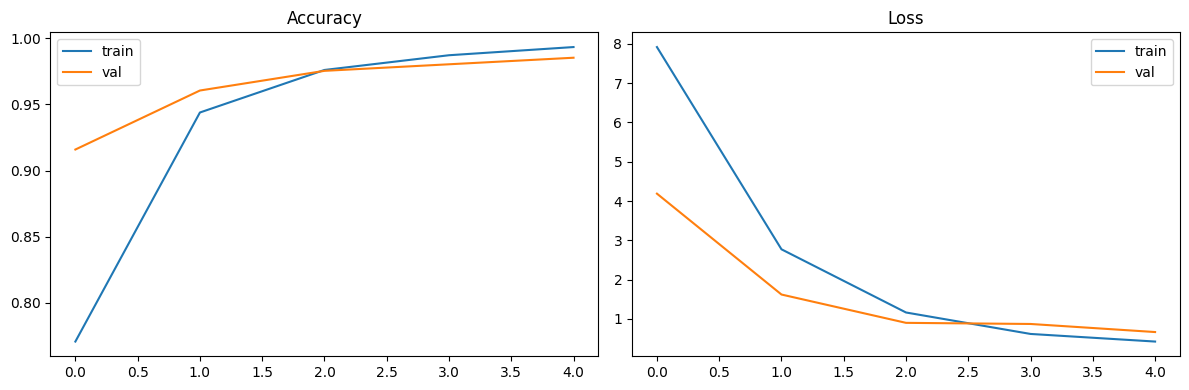

In [11]:
train_accs = [x['train_acc'] for x in histories]
train_losses = [x['train_loss'] for x in histories]
val_accs = [x['val_acc'] for x in histories]
val_losses = [x['val_loss'] for x in histories]

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_accs, label='train')
plt.plot(val_accs, label='val')
plt.title('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='train')
plt.plot(val_losses, label='val')
plt.title('Loss')
plt.legend()

plt.tight_layout()
plt.show()

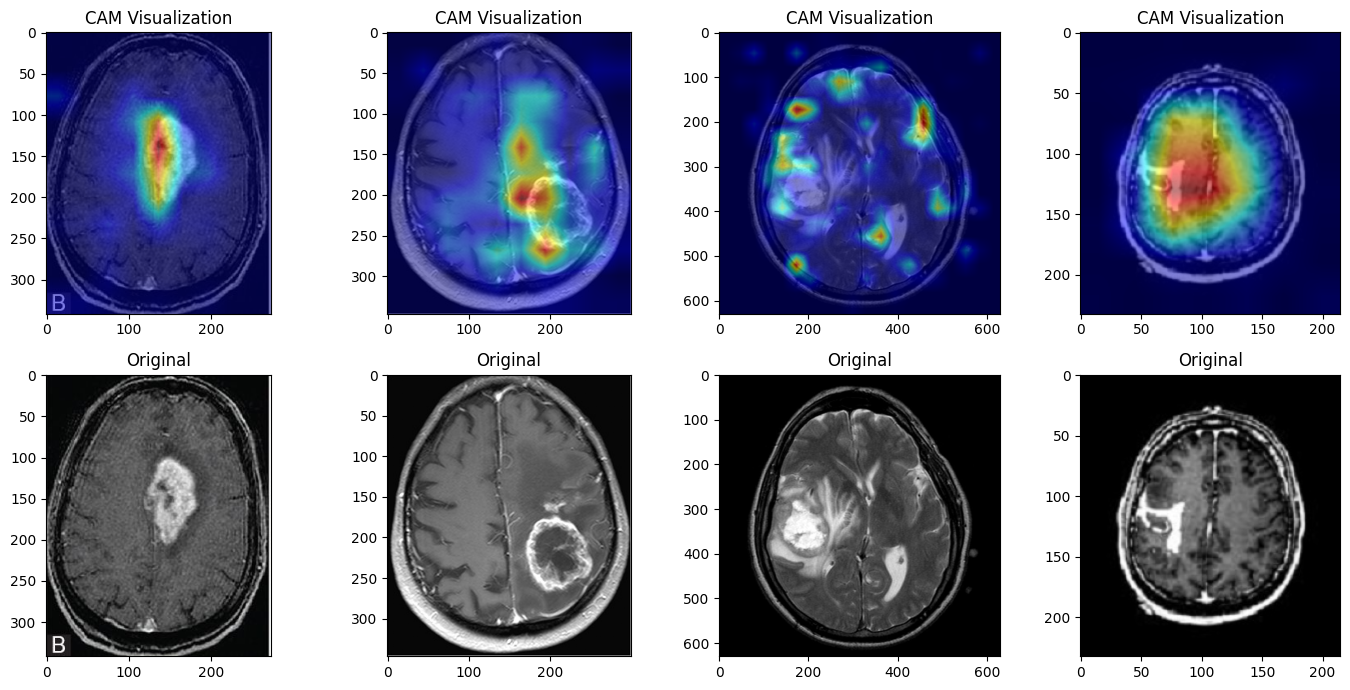

In [12]:
def plot_cam(model, image_paths, targets):
    model = model.eval()
    target_layer = [model.layer4[-1]]
    cam = GradCAM(model=model, target_layers=target_layer)

    fig, axs = plt.subplots(2, 4, figsize=(14, 7))

    for i, (image_path, target) in enumerate(zip(image_paths, targets)):
        image = Image.open(image_path).convert('RGB')
        image_tensor = transforms.ToTensor()(image).unsqueeze(0)
        
        image = transforms.ToTensor()(image)
        image = image.numpy().transpose((1, 2, 0))
        image = np.clip(image, 0, 1)
        
        targets = [ClassifierOutputTarget(target)]
        grayscale_cam = cam(input_tensor=image_tensor, targets=targets)
        grayscale_cam = grayscale_cam[0, :]

        visualization = show_cam_on_image(np.array(image_tensor[0].permute(1, 2, 0)), grayscale_cam, use_rgb=True)

        axs[1, i].imshow(image)
        axs[1, i].set_title('Original')

        axs[0, i].imshow(visualization)
        axs[0, i].set_title('CAM Visualization')

    plt.tight_layout()
    plt.savefig("image.png")
    plt.show()

# Get all image paths from the test data folder
image_paths = [os.path.join(tumors_path, filename) for filename in os.listdir(tumors_path)]

# Select five random image paths
random_image_paths = random.sample(image_paths, 4)

# Assume all images are of class 1
targets = [1] * 4

plot_cam(best_model, random_image_paths, targets)

# References

- [Advanced AI explainability for PyTorch](https://github.com/jacobgil/pytorch-grad-cam)
- [Transfer Learning for Computer Vision Tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)